# Run a "simple" N-body model to produce tidal tails

We will use [AMUSE](https://www.amusecode.org/) to run the N-body model and [galpy](https://docs.galpy.org/en/v1.8.3/) for the galactic potential.  To start, we will follow this example in the galpy docs : https://docs.galpy.org/en/v1.8.2/potential.html 

## Installing AMUSE can somtimes be difficult...

Here's what I did:

```
sudo apt-get install build-essential gfortran \
  libopenmpi-dev openmpi-bin \
  libgsl-dev cmake libfftw3-3 libfftw3-dev \
  libgmp3-dev libmpfr6 libmpfr-dev \
  libhdf5-serial-dev hdf5-tools \
  libblas-dev liblapack-dev 

conda create --name amuse-wsl python=3.10
conda activate amuse-wsl
conda install galpy jupyter astropy pandas matplotlib numpy scipy docutils mpi4py h5py wheel

pip install amuse-framework
pip install amuse-BHtree

```

In [3]:
# for running the n-body simulation using AMUSE
from amuse.lab import * # note this will replace astropy units (if not renamed)
from amuse.couple import bridge
from amuse.datamodel import Particles
from galpy.potential import to_amuse
from galpy.util import plot as galpy_plot
from galpy.potential.mwpotentials import MWPotential2014

from galpy.potential import MiyamotoNagaiPotential
from galpy.potential import KuzminDiskPotential
from galpy.potential import KeplerPotential
from galpy.util import conversion
MWPotential2014wBH= MWPotential2014+KeplerPotential(amp=4*10**6./conversion.mass_in_msol(220.,8.))

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
# Convert galpy MWPotential2014 to AMUSE representation
mwp_amuse = to_amuse(MWPotential2014)
#mwp_amuse = to_amuse(MiyamotoNagaiPotential(a=0.5,b=0.0375,normalize=1.))
#mwp_amuse = to_amuse(KuzminDiskPotential(amp=1.0, a=1.0, normalize=False, ro=None, vo=None))


# Set initial cluster parameters
N = 3000
Mcluster = 3000. | units.MSun
Rcluster = 5. | units.parsec

# define astarting position and velocity (we will update this later)
Rinit= [10.,0.,0.] | units.kpc
Vinit= [0.,220.,0.] | units.km/units.s

# Setup star cluster simulation
tend = 100 | units.Myr
dt = 1.0 | units.Myr

def setup_cluster(N,Mcluster,Rcluster,Rinit,Vinit):
    converter = nbody_system.nbody_to_si(Mcluster,Rcluster)
    stars = new_plummer_sphere(N,converter)
    stars.x += Rinit[0]
    stars.y += Rinit[1]
    stars.z += Rinit[2]
    stars.vx += Vinit[0]
    stars.vy += Vinit[1]
    stars.vz += Vinit[2]
    return stars,converter

# Setup cluster
stars, converter = setup_cluster(N, Mcluster, Rcluster, Rinit, Vinit)
cluster_code = BHTree(converter, number_of_workers = 4) #Change number of workers depending no. of CPUs
cluster_code.parameters.epsilon_squared = (3. | units.parsec)**2
cluster_code.parameters.opening_angle = 0.6
cluster_code.parameters.timestep = dt
cluster_code.particles.add_particles(stars)

# Setup channels between stars particle dataset and the cluster code
channel_from_stars_to_cluster_code = stars.new_channel_to(cluster_code.particles,
                                       attributes=["mass", "x", "y", "z", "vx", "vy", "vz"])
channel_from_cluster_code_to_stars = cluster_code.particles.new_channel_to(stars,
                                       attributes=["mass", "x", "y", "z", "vx", "vy", "vz"])

# Setup gravity bridge
gravity = bridge.Bridge(use_threading=False)
# Stars in cluster_code depend on gravity from external potential mwp_amuse (i.e., MWPotential2014)
gravity.add_system(cluster_code, (mwp_amuse,))
# External potential mwp_amuse still needs to be added to system so it evolves with time
gravity.add_system(mwp_amuse,)
# Set how often to update external potential
gravity.timestep = cluster_code.parameters.timestep/2.

In [5]:
# Evolve
time = 0.0 | tend.unit
count = 0
while time < tend:
    tuse = time + dt
    if (tuse > tend):
        tuse = tend
    gravity.evolve_model(tuse)
    
    # If you want to output or analyze the simulation, you need to copy
    # stars from cluster_code
#     if (count == 0):
#         channel_from_cluster_code_to_stars.copy()
#         stars0 = stars.copy()
#         break
        
    # If you edited the stars particle set, for example to remove stars from the
    # array because they have been kicked far from the cluster, you need to
    # copy the array back to cluster_code:
    #channel_from_stars_to_cluster_code.copy()

    # Update time
    time = gravity.model_time
    
    # print the time to keep track of progress
    count += 1
    if (count % 5 == 0):
        print(f'{time.value_in(units.Myr)} Myr')
        
channel_from_cluster_code_to_stars.copy()
gravity.stop()

5.000000000000001 Myr
10.000000000000002 Myr
15.0 Myr
20.000000000000004 Myr
25.0 Myr
30.0 Myr
35.0 Myr
40.00000000000001 Myr
45.00000000000001 Myr
50.0 Myr
55.0 Myr
60.0 Myr
65.0 Myr
70.0 Myr
75.00000000000001 Myr
80.00000000000001 Myr
85.00000000000001 Myr
90.00000000000001 Myr
95.00000000000001 Myr
100.0 Myr


## Look at the output

In [6]:
print(stars.vx)

[-176464.885972, -176593.986939, -176735.143833, -176241.773703, -176676.394786, -176423.131613, -176927.929471, -176528.850383, -177301.307647, -176215.20401, -176762.292916, -176404.57297, -175635.893233, -177077.592281, -175804.433375, -176252.089369, -176494.632423, -177365.091818, -176906.78034, -176812.625456, -176675.789056, -177259.951976, -176991.006506, -176428.935503, -176393.113375, -176528.760313, -177312.827503, -176517.239984, -176879.130761, -176373.884259, -177143.5361, -176797.897294, -176613.344447, -176197.664861, -177538.640176, -177438.596795, -177155.293517, -177363.557768, -176063.647939, -176959.456288, -176094.365807, -176686.206011, -176000.057359, -176922.572096, -177296.930266, -177518.525973, -176492.121704, -178099.470979, -176798.612702, -176988.132968, -176444.782545, -177686.528236, -177000.268656, -176611.404167, -176608.32575, -177514.51819, -176468.92388, -176574.551838, -176507.080204, -177214.74939, -176024.262803, -176417.785352, -177460.3855, -1

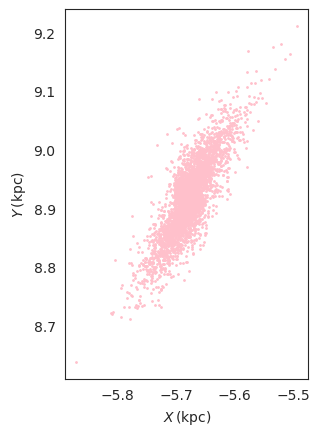

In [16]:
# create a scatter plot

f, ax = plt.subplots()

ax.scatter(stars.x.value_in(units.kpc), stars.y.value_in(units.kpc), s = 1, color = 'pink')

ax.set_xlabel(r'$X\,(\mathrm{kpc})$')
ax.set_ylabel(r'$Y\,(\mathrm{kpc})$')
ax.set_aspect('equal')

## Save the simulation data to reuse later 

In [ ]:
# pickle this so that I can use it later without re-running the model
f = open('qcjlkqjd.pickle', 'ab')
pickle.dump(stars, f)                     
f.close()

In [13]:
import pickle 
f = open('30k.pickle', 'rb')
stars = pickle.load(f)
print(stars)

                 key         mass       radius           vx           vy           vz            x            y            z
                   -           kg            m    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 4980474376243147516    1.989e+29    0.000e+00   -1.774e+05   -1.100e+05   -5.672e+02   -1.751e+20    2.754e+20    1.345e+17
17969789794478115323    1.989e+29    0.000e+00   -1.771e+05   -1.094e+05    5.843e+02   -1.755e+20    2.749e+20    1.468e+17
16179541286089898020    1.989e+29    0.000e+00   -1.766e+05   -1.097e+05    2.750e+02   -1.751e+20    2.755e+20   -1.039e+17
13176499689151618128    1.989e+29    0.000e+00   -1.768e+05   -1.104e+05   -6.608e+02   -1.752e+20    2.752e+20    1.655e+17
10341550374595479400    1.989e+29    0.000e+00   -1.770e+05   -1.104e+05    5.126e+02   -1.751e+20    2.752e+20    1.581e+17


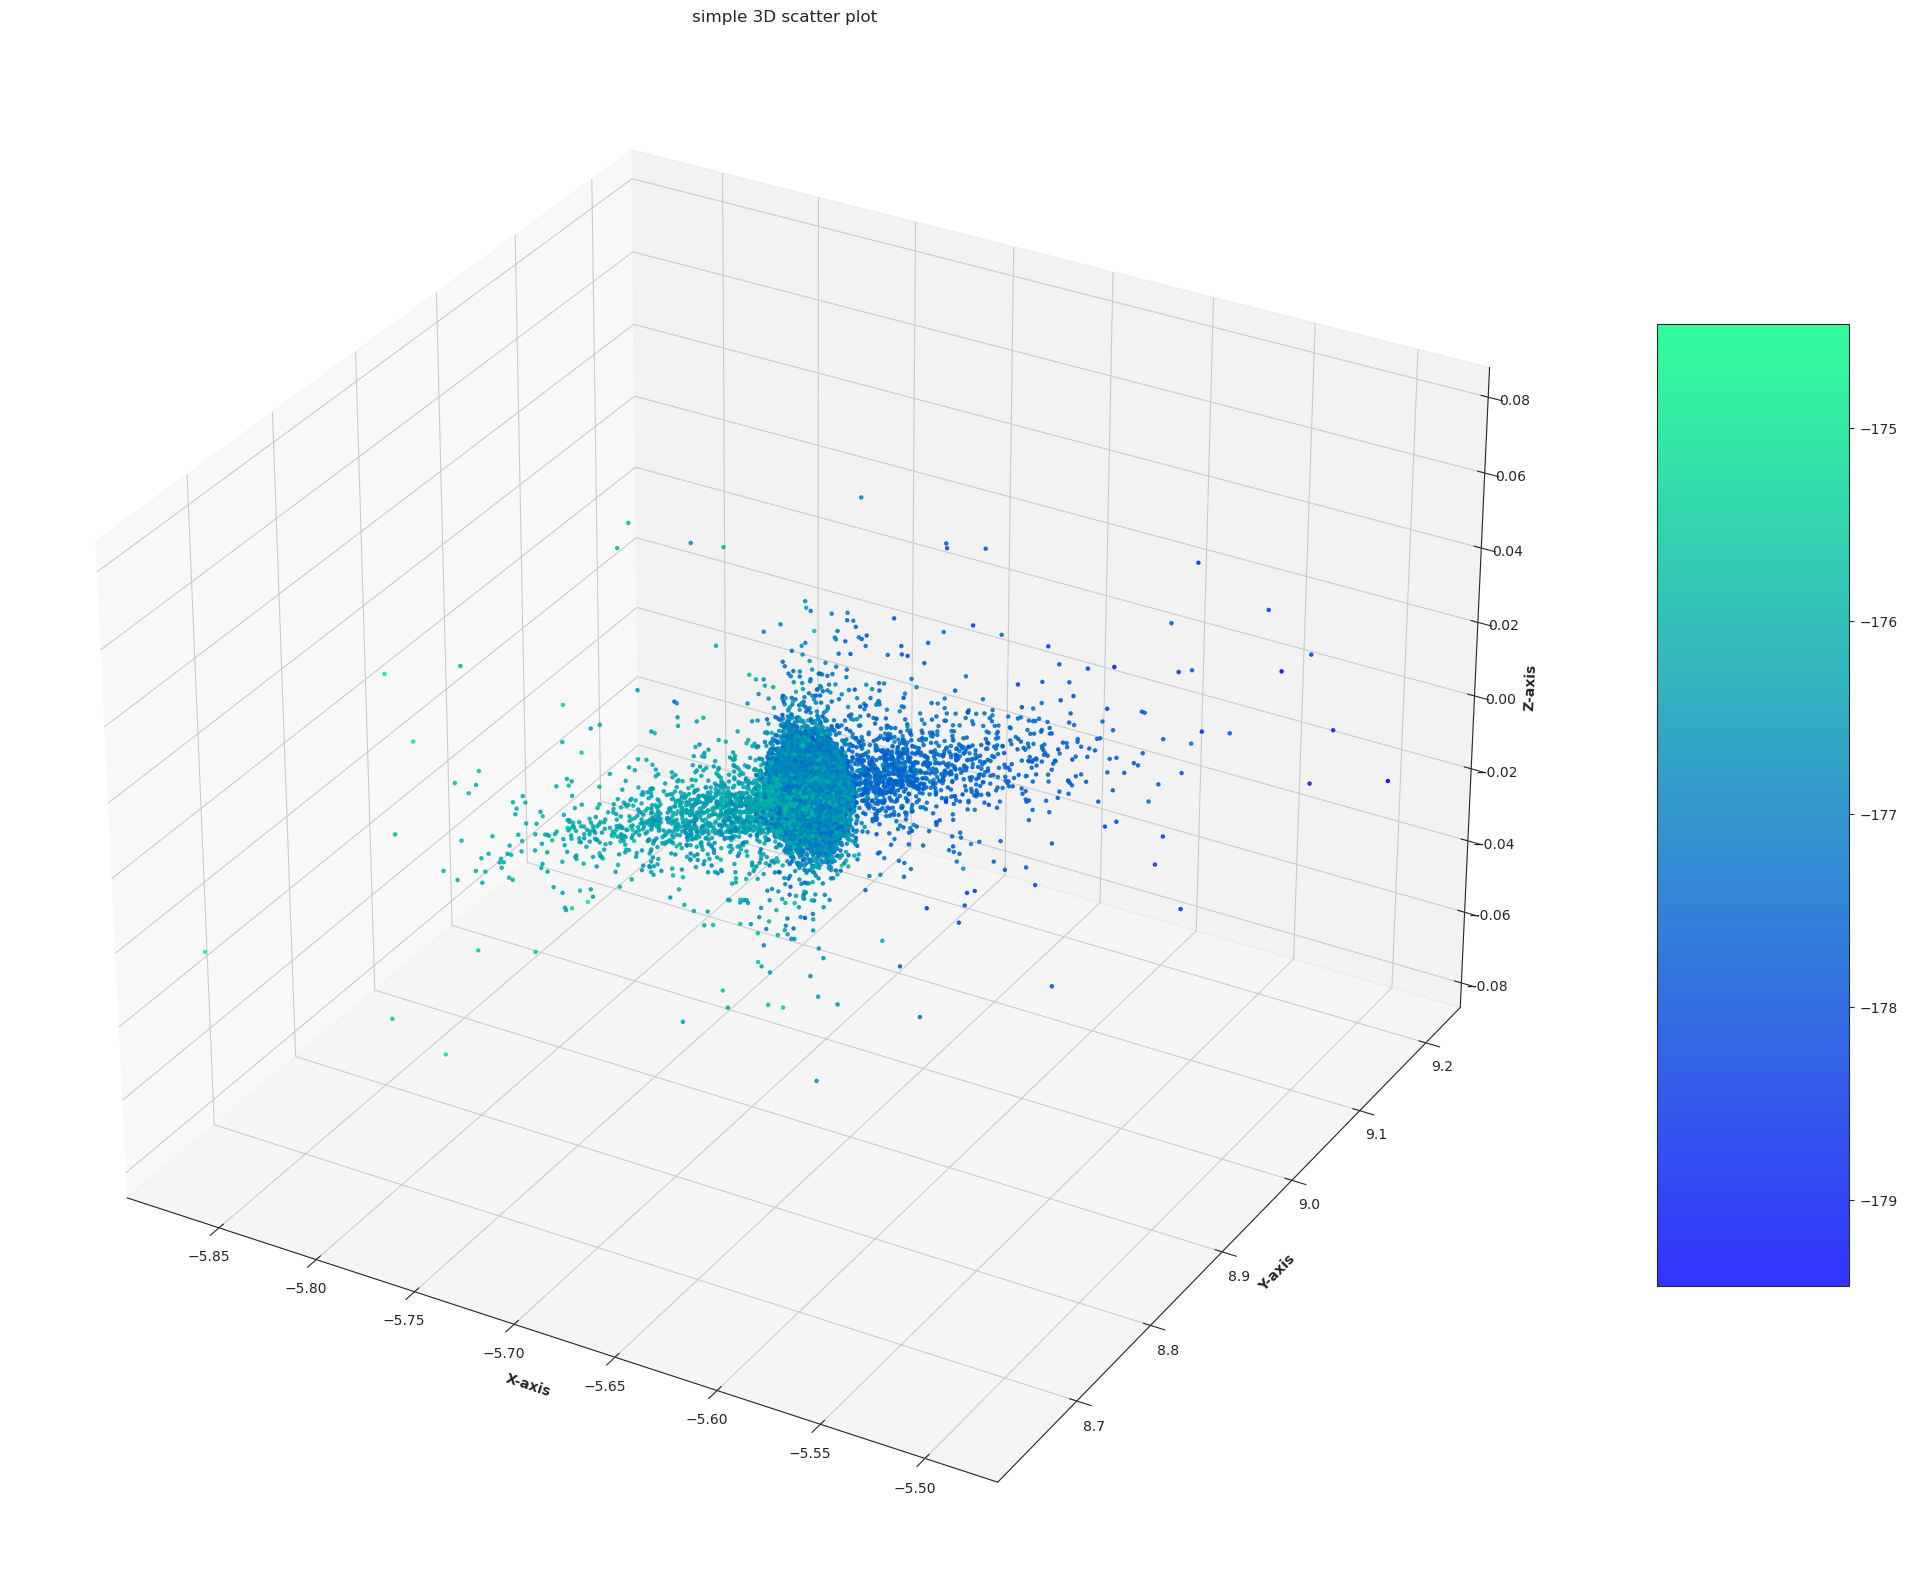

In [14]:
# Import libraries
from mpl_toolkits import mplot3d



# Creating dataset
z = stars.z.value_in(units.kpc)#4 * np.tan(np.random.randint(10, size =(500))) + np.random.randint(100, size =(500))
x = stars.x.value_in(units.kpc)#4 * np.cos(z) + np.random.normal(size = 500)
y = stars.y.value_in(units.kpc)#4 * np.sin(z) + 4 * np.random.normal(size = 500)

# Creating figure
fig = plt.figure(figsize = (25, 25))#figsize = (25, 16))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
linestyle ='-.', linewidth = 0.3,
alpha = 0.2)


# Creating color map
my_cmap = plt.get_cmap('winter')

# Creating plot
sctt = ax.scatter3D(x, y, z,
alpha = 0.8,
c = (stars.vx.value_in(units.km/units.s)),
cmap = my_cmap,
marker ='.')

plt.title("simple 3D scatter plot")
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

# show plot
plt.show()

In [9]:
import plotly.express as px
import seaborn as sns

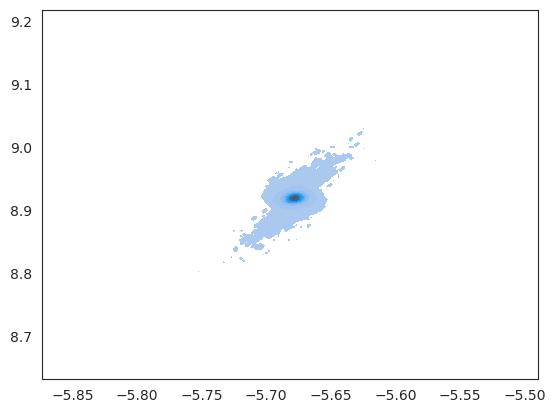

In [15]:
sns.set_style("white")
sns.color_palette("mako", as_cmap=True)

sns.kdeplot(x=stars.x.value_in(units.kpc), y=stars.y.value_in(units.kpc), fill=True, bw_adjust=.5)
plt.show()

In [17]:
#use plotly for interactive data, get a better look at the tidal tails in space
#use seaborn for contour maps, which will give a better understanding of the densities in space


z = stars.z.value_in(units.kpc)
x = stars.x.value_in(units.kpc)
y = stars.y.value_in(units.kpc)
vx = stars.vx.value_in(units.km/units.s)

fig = px.scatter_3d(x=x, y=y, z=z, color=vx)
fig.show()

In [18]:
import galpy.potential
print([p for p in dir(galpy.potential) if 'Potential' in p])

['AdiabaticContractionWrapperPotential', 'AnyAxisymmetricRazorThinDiskPotential', 'AnySphericalPotential', 'BurkertPotential', 'CorotatingRotationWrapperPotential', 'CosmphiDiskPotential', 'DehnenBarPotential', 'DehnenCoreSphericalPotential', 'DehnenSmoothWrapperPotential', 'DehnenSphericalPotential', 'DiskSCFPotential', 'DoubleExponentialDiskPotential', 'EllipsoidalPotential', 'EllipticalDiskPotential', 'FerrersPotential', 'FlattenedPowerPotential', 'GaussianAmplitudeWrapperPotential', 'HenonHeilesPotential', 'HernquistPotential', 'HomogeneousSpherePotential', 'InterpSnapshotRZPotential', 'IsochronePotential', 'IsothermalDiskPotential', 'JaffePotential', 'KGPotential', 'KeplerPotential', 'KingPotential', 'KuzminDiskPotential', 'KuzminKutuzovStaeckelPotential', 'LogarithmicHaloPotential', 'LopsidedDiskPotential', 'MN3ExponentialDiskPotential', 'MWPotential', 'MWPotential2014', 'MiyamotoNagaiPotential', 'MovingObjectPotential', 'NFWPotential', 'NullPotential', 'NumericalPotentialDerivat

In [28]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianDifferential


92.2250000023 92.225
24.3499999996 24.35
9.26146322471 9.26146322471 -9.261463224710228 kpc
-0.131379211948 -0.131379211948 -0.13137921194811894 kpc
0.0677719580511 0.0677719580511 0.0677719580511143 kpc


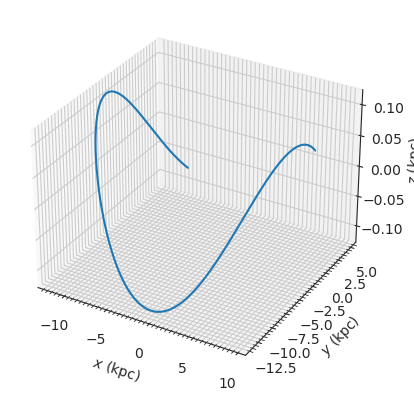

In [44]:
from galpy.orbit import Orbit

coord2168 = SkyCoord(

    ra = (6. + 8./60. + 54./3600.)*15.*u.deg, dec = (24. + 21./60. + 0./3600.)*u.deg, 

    distance = 1148.*u.pc,

    pm_ra_cosdec = -2.56*u.mas/u.yr, pm_dec = 0.18*u.mas/u.yr, radial_velocity = -8.16*u.km/u.s,

    # from galpy : https://docs.galpy.org/en/v1.8.2/orbit.html

    # I made the x direction for galcen_v_sun negative because of the different handedness of the coordinate system in galpy (I think!)

    galcen_distance = 8.*u.kpc, z_sun = 15.*u.pc,

    galcen_v_sun = CartesianDifferential([-10.0, 235., 7.]*u.km/u.s),

    frame = 'icrs'

)

c2168 = coord2168.transform_to('galactocentric').copy()

c2168.representation_type = 'cylindrical'



o = Orbit(c2168).flip() #flip integrates it backwards

tend0 = 213 # age of M35



# define times and integrate

ts = np.linspace(0., tend0, 10000)*u.Myr

o.integrate(ts, MWPotential2014)



print(o.ra(), coord2168.ra.value)

print(o.dec(), coord2168.dec.value)



print(o.x(ts)[0], o.x(), c2168.cartesian.x.to(u.kpc))

print(o.y(ts)[0], o.y(), c2168.cartesian.y.to(u.kpc))

print(o.z(ts)[0], o.z(), c2168.cartesian.z.to(u.kpc))



o.plot3d()

11.802083345 11.8020833333
85.2469444475 85.2469444444
8.94771294631 8.94771294631 -8.947712946309082 kpc
1.28196990981 1.28196990981 1.2819699098133328 kpc
0.651043838563 0.651043838563 0.6510438385626238 kpc


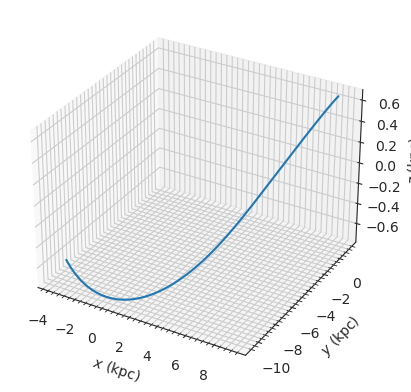

In [45]:
from galpy.orbit import Orbit
coord188 = SkyCoord(
    ra = (0. + 47./60. + 12.5/3600.)*15.*u.deg, dec = (85. + 14./60. + 49./3600.)*u.deg, 
    distance = 1650.*u.pc,
    pm_ra_cosdec = -2.56*u.mas/u.yr, pm_dec = 0.18*u.mas/u.yr, radial_velocity = -42.4*u.km/u.s,
    # from galpy : https://docs.galpy.org/en/v1.8.2/orbit.html
    # I made the x direction for galcen_v_sun negative because of the different handedness of the coordinate system in galpy (I think!)
    galcen_distance = 8.*u.kpc, z_sun = 15.*u.pc,
    galcen_v_sun = CartesianDifferential([-10.0, 235., 7.]*u.km/u.s),
    frame = 'icrs'
)
c188 = coord188.transform_to('galactocentric').copy()
c188.representation_type = 'cylindrical'

o = Orbit(c188).flip()
tend0 = 100 # age of M35

# define times and integrate
ts = np.linspace(0., tend0, 10000)*u.Myr
o.integrate(ts, MWPotential2014)

print(o.ra(), coord188.ra.value)
print(o.dec(), coord188.dec.value)

print(o.x(ts)[0], o.x(), c188.cartesian.x.to(u.kpc))
print(o.y(ts)[0], o.y(), c188.cartesian.y.to(u.kpc))
print(o.z(ts)[0], o.z(), c188.cartesian.z.to(u.kpc))

o.plot3d()

In [30]:
import pandas as pd

In [42]:
M35_data = pd.read_csv('M_35.df')
#M35_data[ra]
#M35_data[dec]
M35_data

source_id ra dec pmra pmdec radial_velocity G phot_g_mean_flux_over_error G_BP phot_bp_mean_flux_over_error G_RP phot_rp_mean_flux_over_error parallax teff_gspphot ruwe number_of_neighbours number_of_mates g_ps sigg_ps r_ps sigr_ps i_ps sigi_ps z_ps sigz_ps y_ps sigy_ps J_2M sigJ_2M H_2M sigH_2M Ks_2M sigKs_2M sigG sigG_BP sigG_RP coord.ra coord.dec rCenter id PPa sig_E(B-V) E(B-V) phot_rp_mean_mag_eror PRV PM_ra PM_dec PPM CMprior member binary m1Median qMedian
0     0 3429632162972554368 90.6884410880764 25.3287...                                                                                                                                                                                                                                                                                                                                                                                                                                 
1     1 3429632923179319296 90.73903345124224 25.397...                                                                                                                                                                                                                                                                                                                                                                                                                                 
2     2 3429633576018908160 90.6924974807891 25.3936...                                                                                                                                                                                                                                                                                                                                                                                                                                 
3     3 3429633674801029248 90.74081451584574 25.409...                                                                                                                                                                                                                                                                                                                                                                                                                                 
4     4 3429634946107551744 90.80753428372564 25.448...                                                                                                                                                                                                                                                                                                                                                                                                                                 
...                                                 ...                                                                                                                                                                                                                                                                                                                                                                                                                                 
3488  3488 3425853901713962752 93.42685806692694 24....                                                                                                                                                                                                                                                                                                                                                                                                                                 
3489  3489 3425855271810714112 93.23336335144305 24....                                                                                                                                                                       